# Training Linear Models

## Imports and Parameters

In [76]:
import pandas as pd
import numpy as np
from pathlib import Path

In [77]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [78]:
# Used for sound signal
from playsound import playsound
alarm_file = Path().parent / '../Sounds' / 'alarm.wav'

1. Try to build a classifier for the MNIST dataset that achieves over 97%
accuracy on the test set. Hint: the KNeighborsClassifier works
quite well for this task; you just need to find good hyperparameter
values (try a grid search on the weights and n_neighbors
hyperparameters).

In [79]:
# Get the data
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [80]:
# Divide the data into training and test sets
from sklearn.model_selection import train_test_split

X = mnist.data
y = mnist.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
# Usefull function to plot the images
def plot_digit(data, shape=(28, 28), figsize=(3,3), cmap='binary', interpolation='nearest'):
	image = data.reshape(shape)
	plt.figure(figsize=figsize)
	plt.imshow(image, cmap=cmap, interpolation=interpolation)
	plt.axis('off')

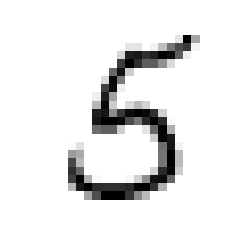

In [82]:
some_index = 0
plot_digit(X_train[some_index])

In [83]:
# Using a KNN classifier
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4)

In [84]:
# Cross-val with this hyperparameter
from sklearn.model_selection import cross_val_score

scores = cross_val_score(knn_clf, X_train, y_train, cv=3, scoring='accuracy')

In [85]:
scores

array([0.97037553, 0.97198264, 0.96940962])

In [86]:
def weight_function(distances):
	return 1 / distances**2

In [87]:
# Using GridSearchCV to find the best hyperparameters
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance', weight_function]}]

grid_search = GridSearchCV(knn_clf, param_grid, cv=3, verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3,
             estimator=KNeighborsClassifier(n_jobs=-1, n_neighbors=4,
                                            weights='distance'),
             n_jobs=-1,
             param_grid=[{'n_neighbors': [3, 5, 7],
                          'weights': ['uniform', 'distance',
                                      <function weight_function at 0x0000011A242532E0>]}],
             verbose=3)

In [88]:
grid_search.best_params_

{'n_neighbors': 3, 'weights': <function __main__.weight_function(distances)>}

In [91]:
grid_search.best_estimator_.predict([X_train[some_index]])

C:\Users\Denis\AppData\Local\Temp\ipykernel_9304\1938018940.py:2: RuntimeWarning: divide by zero encountered in divide
  return 1 / distances**2


array(['5'], dtype=object)